_version log: creating a nice graph for 3 laser sources_

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
plt.rcParams.update({'font.size':14})

pixel_pitch = 9.9 #um

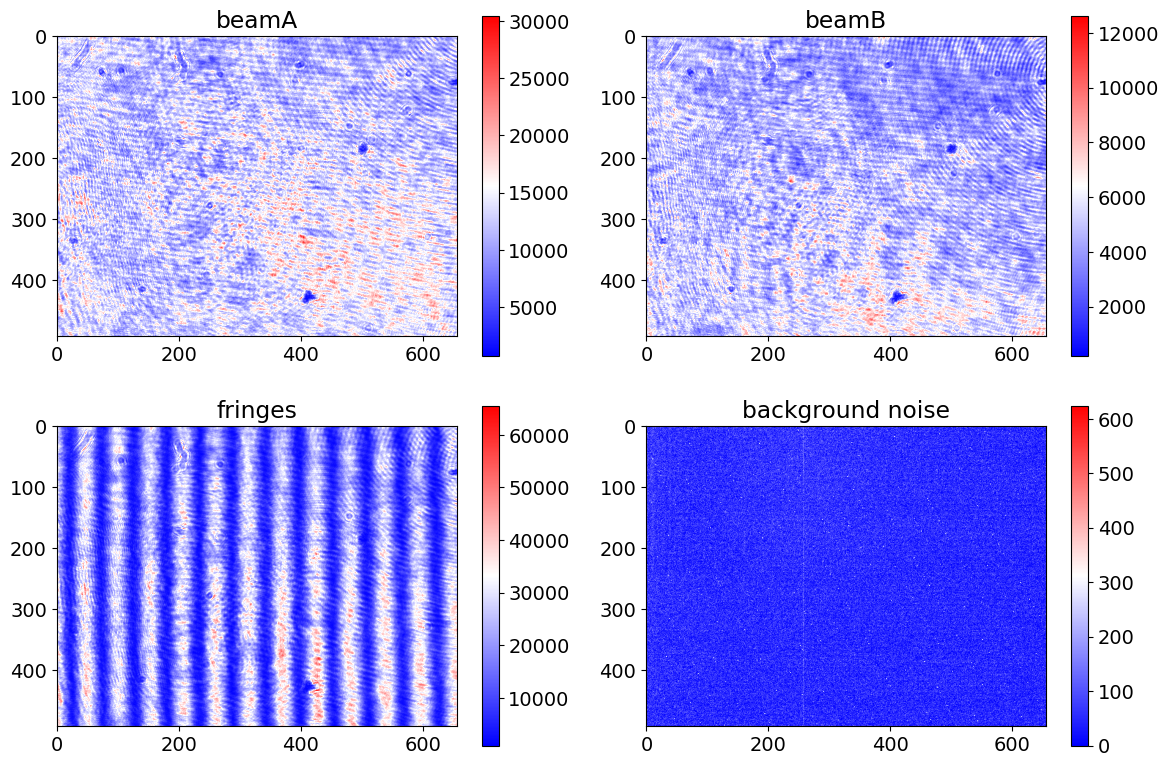

In [2]:
def import_standard_tif(colour, number):
    im = Image.open('data\\'+colour+'_fringes'+number+'.tif')
    fringes = np.array(im, dtype= np.float32)
    im = Image.open('data\\'+colour+'_BA'+number+'.tif')
    beamA = np.array(im, dtype= np.float32)
    im = Image.open('data\\'+colour+'_BB'+number+'.tif')
    beamB = np.array(im, dtype= np.float32)
    im = Image.open('data\\'+colour+'_bg'+number+'.tif')
    background = np.array(im, dtype= np.float32)
    return fringes, beamA, beamB, background

blue_f, blue_BA, blue_BB, blue_bg = import_standard_tif("blue", "3")
red_f, red_BA, red_BB, red_bg = import_standard_tif("red", "9")
green_f, green_BA, green_BB, green_bg = import_standard_tif("green", "13")

plt.figure(figsize= (12,8))

plt.subplot(2,2,1)
im=plt.imshow(blue_BA, cmap='bwr')
plt.colorbar(im)
plt.title("beamA")

plt.subplot(2,2,2)
im=plt.imshow(blue_BB, cmap='bwr')
plt.colorbar(im)
plt.title("beamB")

plt.subplot(2,2,3)
im=plt.imshow(blue_f, cmap='bwr')
plt.colorbar(im)
plt.title("fringes")

plt.subplot(2,2,4)
im=plt.imshow(blue_bg, cmap='bwr')
plt.colorbar(im)
plt.title("background noise")

plt.tight_layout()
plt.show()

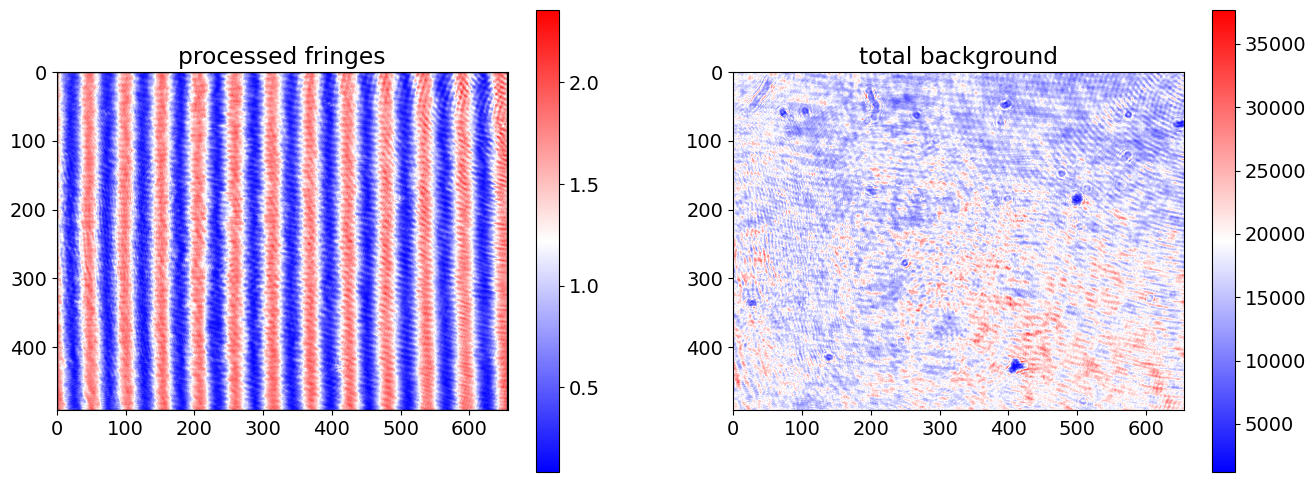

In [3]:
ROI = [[0,491],[0,655]] #region of interest in rows, columns. [[0,491],[0,655]]

def process_fringes(fringes, beamA, beamB, background):
    nofringes = beamA +beamB -background

    if False: #toggle which meathod you want to use. IDK which one is better.
        beamPost = fringes - nofringes #take away background. This meathod exaggerates the bandwidth.
    else:
        beamPost = fringes / nofringes #normalise using background. This meathod suffers with div0 errors and exaggerates the noise.
        beamPost = np.nan_to_num(beamPost, #This is unphysical but so is infinate intensity.
                                posinf= np.nanmax(beamPost[np.isfinite(beamPost)]), #occors for x/0
                                neginf= np.nanmin(beamPost[np.isfinite(beamPost)]), #occors for -x/0. this should be impossible
                                nan= 0) #occors for 0/0
        
    return beamPost, nofringes

blue_post, blue_nof = process_fringes(blue_f, blue_BA, blue_BB, blue_bg)
red_post, red_nof = process_fringes(red_f, red_BA, red_BB, red_bg)
green_post, green_nof = process_fringes(green_f, green_BA, green_BB, green_bg)

plt.figure(figsize = (16,6))

ax = plt.subplot(1,2,1)
im=plt.imshow(blue_post, cmap='bwr')
plt.colorbar(im)
plt.title("processed fringes")

# Create a Rectangle patch
rect = patches.Rectangle((ROI[1][0], ROI[0][0]), ROI[1][1]-ROI[1][0], ROI[0][1]-ROI[0][0], linewidth=1, edgecolor='k', facecolor='none')
ax.add_patch(rect)

plt.subplot(1,2,2)
im=plt.imshow(blue_nof, cmap='bwr')
plt.colorbar(im)
plt.title("total background")

plt.show()

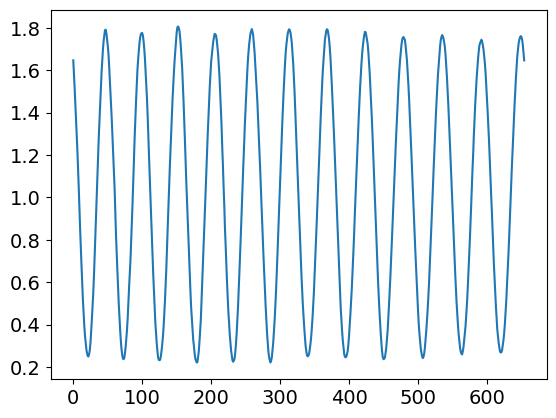

In [4]:
blue_average = np.mean(blue_post[ROI[0][0]:ROI[0][1], ROI[1][0]:ROI[1][1]], axis = 0)
red_average = np.mean(red_post[ROI[0][0]:ROI[0][1], ROI[1][0]:ROI[1][1]], axis = 0)
green_average = np.mean(green_post[ROI[0][0]:ROI[0][1], ROI[1][0]:ROI[1][1]], axis = 0)

plt.plot(blue_average)
plt.show()


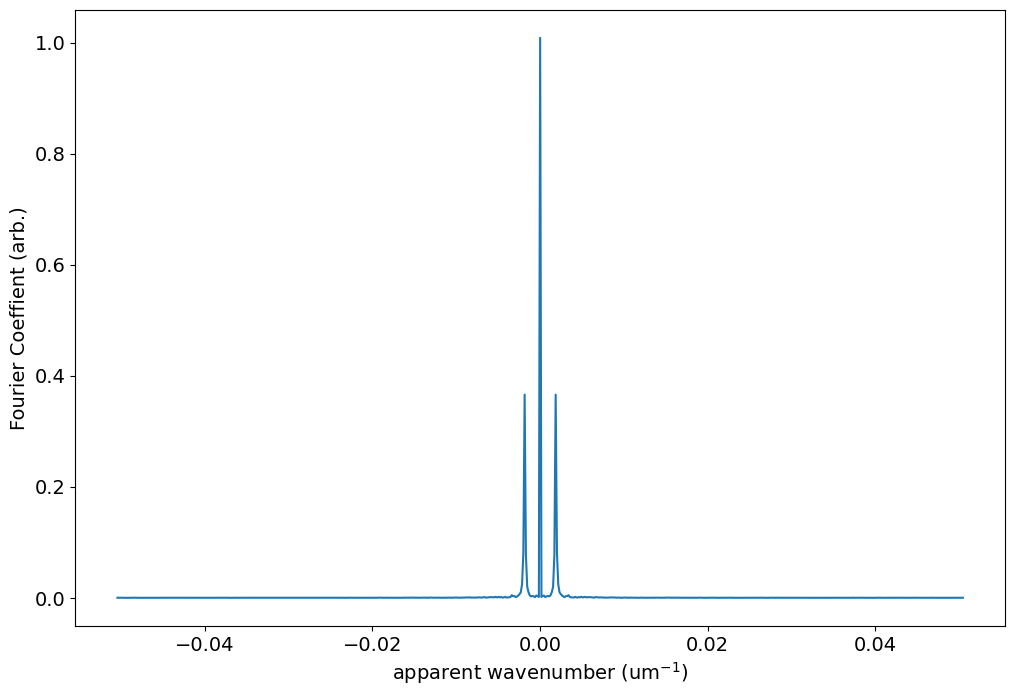

In [5]:
def FourierAndWavenumbers(signal):
        FT = np.fft.fft(signal, norm = "forward")
        freqs = np.fft.fftfreq(len(FT), pixel_pitch)
        return FT, freqs

blue_FT, freqs = FourierAndWavenumbers(blue_average)
red_FT, freqs = FourierAndWavenumbers(red_average)
green_FT, freqs = FourierAndWavenumbers(green_average)

plt.figure(figsize = (12,8))
plt.subplot(1, 1, 1)

plt.plot(np.fft.fftshift(freqs), #fftshift will put the frequencies is acending order which is useful because plt plots in acending order.
        abs(np.fft.fftshift(blue_FT)))

plt.xlabel('apparent wavenumber (um$^{-1}$)')
plt.ylabel('Fourier Coeffient (arb.)')

plt.show()

C:\Users\syf83691\AppData\Local\Temp\ipykernel_14040\2040407741.py:19: RuntimeWarning: divide by zero encountered in divide
  wavelengths = 1/freqs[:num_of_freqs]


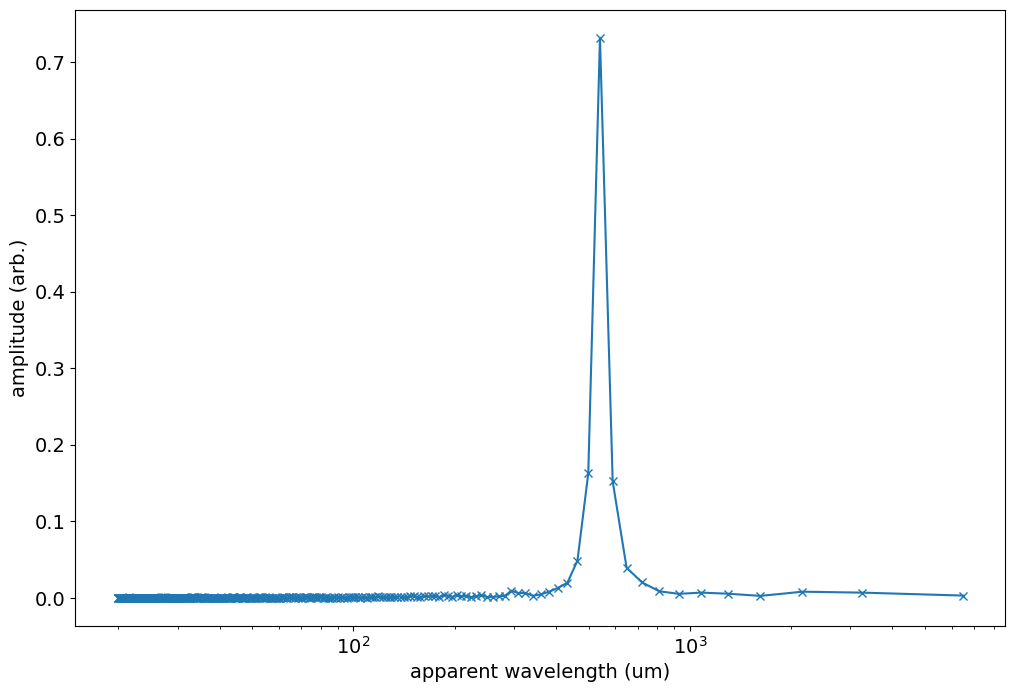

In [6]:
def Coeffients2Amplitudes(FT, freqs):
        samples = len(FT)
        num_of_freqs = len(FT)//2 +1
        amplitude = np.zeros(num_of_freqs)
        amplitude[0] = np.abs(FT[0])

        if (samples//2 == samples/2): #if even
                amplitude[num_of_freqs-1] = np.abs(FT[num_of_freqs-1])
                amplitude[1:-1] = (np.abs( FT[1:num_of_freqs-1] ) +
                                np.abs( FT[:num_of_freqs-1:-1] ))

                wavelengths = 1/freqs[:num_of_freqs +1]
                freqs = freqs[:num_of_freqs +1]

        else: #if odd
                amplitude[1:] = (np.abs( FT[1:num_of_freqs] ) +
                                np.abs( FT[:num_of_freqs-1:-1] ))

                wavelengths = 1/freqs[:num_of_freqs]
                freqs = freqs[:num_of_freqs]

        return amplitude, wavelengths, freqs

blue_amps, wavelengths, freqs = Coeffients2Amplitudes(blue_FT, freqs)
red_amps, wavelengths, freqs = Coeffients2Amplitudes(red_FT, freqs)
green_amps, wavelengths, freqs = Coeffients2Amplitudes(green_FT, freqs)

plt.figure(figsize = (12,8))
plt.subplot(1, 1, 1)

plt.plot(wavelengths[:-1], #excule the infinate wavelength
        blue_amps[:-1],
        marker = "x")
plt.xlabel('apparent wavelength (um)')
plt.ylabel('amplitude (arb.)')
plt.xscale("log")
plt.show()

C:\Users\syf83691\AppData\Local\Temp\ipykernel_14040\576047783.py:12: RuntimeWarning: divide by zero encountered in divide
  return 1e4 / x #converts nm to cm^-1 or vice versa. be careful with units


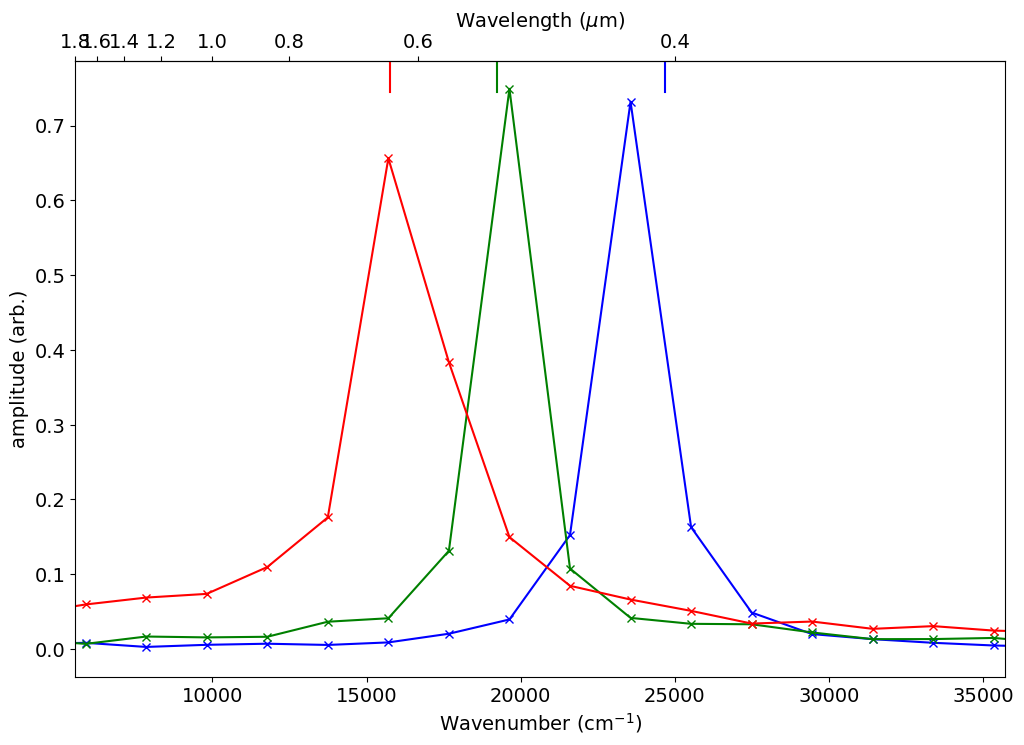

In [7]:
################COMPENSATE FOR ANGLE#################
angle_between_beams = 0.045 # =2*theta. in degrees. Has a large uncertainty

theta = angle_between_beams/2 *np.pi/180 #in radians
corrected_wavelengths = wavelengths *2*np.sin(theta)
corrected_numbers = freqs /2/np.sin(theta)

plt.figure(figsize = (12,8))
ax1 = plt.subplot(1, 1, 1)

def recip(x):
    return 1e4 / x #converts um to cm^-1 or vice versa. be careful with units

ax1.plot(corrected_numbers[1:] *1e4, #excule the infinate wavelength and convert to cm^-1
        blue_amps[1:],
        color = "blue",
        marker = "x")
ax1.plot(corrected_numbers[1:] *1e4,
        green_amps[1:],
        color = "green",
        marker = "x")
ax1.plot(corrected_numbers[1:] *1e4,
        red_amps[1:],
        color = "red",
        marker = "x")
plt.ylabel('amplitude (arb.)')
#plt.xscale("log")
plt.axvline(recip(0.405), ymin = 0.95, color = "blue")
plt.axvline(recip(0.520), ymin = 0.95, color = "green")
plt.axvline(recip(0.635), ymin = 0.95, color = "red")

secax = ax1.secondary_xaxis('top', functions=(recip, recip))
ax1.set_xlabel('Wavenumber (cm$^{-1}$)') #cm^-1 is more sensible in real IR spectroscopy
secax.set_xlabel('Wavelength ($\mu$m)')
plt.xlim(recip(1.800), recip(0.280))

plt.show()